In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box
import fiona
import os
import sklearn
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from folium.features import GeoJsonTooltip
from sklearn.preprocessing import label_binarize, LabelEncoder, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV

DATA COLLECTING

In [6]:
gdb_path = "E:/KULIAH SEMESTER 7/COMPUTING PROJECT/CAPSTONEPROJECT/2022_RBI25K_KAB_BANYUMAS_KUGI50_20221231.gdb"

banyumas_shp = "E:/KULIAH SEMESTER 7/COMPUTING PROJECT/CAPSTONEPROJECT/indonesiaSHPLevel3/gadm41_IDN_3.shp"
banyumas_kab = gpd.read_file(banyumas_shp)
banyumas_kab = banyumas_kab[banyumas_kab["NAME_2"] == "Banyumas"].to_crs(epsg=32749)
banyumas_boundary = banyumas_kab.dissolve(by="NAME_2")

In [7]:
layer_hijau = [
    "HUTANLAHANTINGGI_AR_25K",
    "HUTANLAHANRENDAH_AR_25K",
    "HERBADANRUMPUT_AR_25K",
    "HUTANTANAMAN_AR_25K"
]

list_gdf = []
for layer in layer_hijau:
    gdf = gpd.read_file(gdb_path, layer=layer)
    list_gdf.append(gdf)

area_hijau = gpd.GeoDataFrame(pd.concat(list_gdf, ignore_index=True), crs=list_gdf[0].crs).to_crs(epsg=32749)


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


In [8]:
layer_bangunan = ["PERUMAHAN_AR_25K", "PERMUKIMAN_AR_25K"]
bangunan_list = []

for layer in layer_bangunan:
    try:
        gdf = gpd.read_file(gdb_path, layer=layer)
        bangunan_list.append(gdf)
        print(f"✅ Berhasil baca layer: {layer} ({len(gdf)} fitur)")
    except Exception as e:
        print(f"⚠️ Gagal membaca layer {layer}: {e}")

# Gabung jadi 1 dataframe
bangunan = gpd.GeoDataFrame(
    pd.concat(bangunan_list, ignore_index=True),
    crs=bangunan_list[0].crs
).to_crs(epsg=32749)

jalan = gpd.read_file(gdb_path, layer="JALAN_LN_25K").to_crs(epsg=32749)

✅ Berhasil baca layer: PERUMAHAN_AR_25K (291 fitur)
✅ Berhasil baca layer: PERMUKIMAN_AR_25K (4405 fitur)


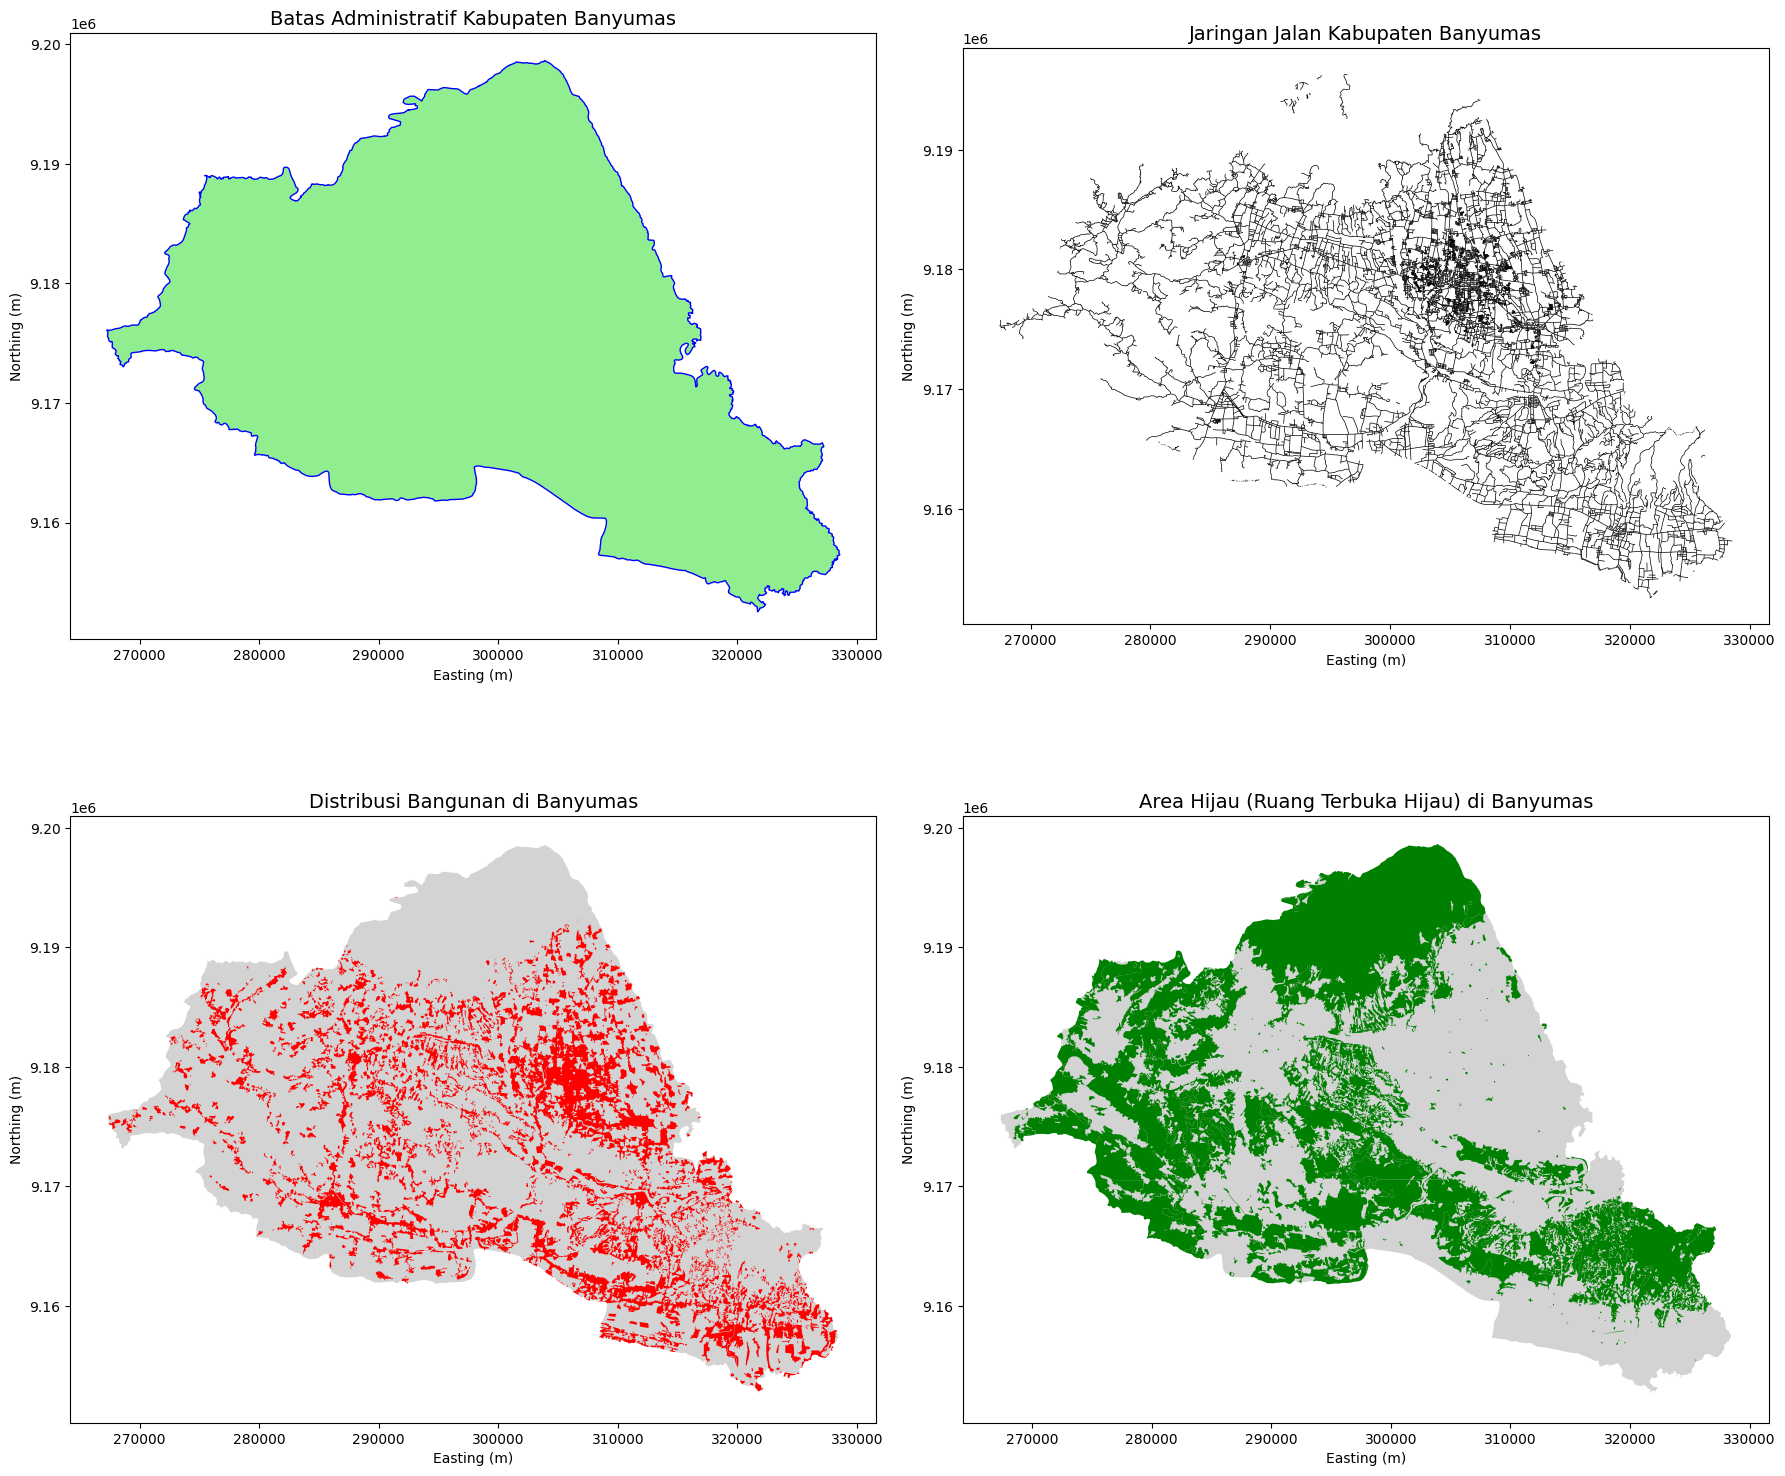

In [9]:
# Clip ke batas banyumas
jalan_bms = gpd.clip(jalan, banyumas_boundary)
bangunan_bms = gpd.clip(bangunan, banyumas_boundary)
area_hijau_bms = gpd.clip(area_hijau, banyumas_boundary)

fig, axs = plt.subplots(2, 2, figsize=(18, 16))

# Batas Administratif
banyumas_boundary.plot(ax=axs[0, 0], color="lightgreen", edgecolor="blue")
axs[0, 0].set_title("Batas Administratif Kabupaten Banyumas", fontsize=14)
axs[0, 0].set_xlabel("Easting (m)")
axs[0, 0].set_ylabel("Northing (m)")

# Jaringan Jalan
jalan_bms.plot(ax=axs[0, 1], color="black", linewidth=0.5)
axs[0, 1].set_title("Jaringan Jalan Kabupaten Banyumas", fontsize=14)
axs[0, 1].set_xlabel("Easting (m)")
axs[0, 1].set_ylabel("Northing (m)")

# Distribusi Bangunan
banyumas_boundary.plot(ax=axs[1, 0], color="lightgrey", edgecolor="white")
bangunan_bms.plot(ax=axs[1, 0], color="red", markersize=0.1)
axs[1, 0].set_title("Distribusi Bangunan di Banyumas", fontsize=14)
axs[1, 0].set_xlabel("Easting (m)")
axs[1, 0].set_ylabel("Northing (m)")

# Area Hijau
banyumas_boundary.plot(ax=axs[1, 1], color="lightgrey", edgecolor="white")
area_hijau_bms.plot(ax=axs[1, 1], color="green")
axs[1, 1].set_title("Area Hijau (Ruang Terbuka Hijau) di Banyumas", fontsize=14)
axs[1, 1].set_xlabel("Easting (m)")
axs[1, 1].set_ylabel("Northing (m)")

plt.tight_layout()
plt.show()


DATA UNDERSTANDING

In [10]:
minx, miny, maxx, maxy = banyumas_kab.total_bounds
grid_size = 500

cols = np.arange(minx, maxx, grid_size)
rows = np.arange(miny, maxy, grid_size)

grid_cells = []
for x in cols:
    for y in rows:
        cell = box(x, y, x + grid_size, y + grid_size)
        grid_cells.append(cell)

grid = gpd.GeoDataFrame({"geometry": grid_cells}, crs=banyumas_kab.crs)
grid = gpd.overlay(grid, banyumas_kab, how="intersection")

In [11]:
def hitung_fitur_per_grid(grid, gdf_area, gdf_bangunan, gdf_jalan):
    hasil = []

    for i, row in grid.iterrows():
        sel_grid = gpd.GeoDataFrame([row], crs=grid.crs)
        geom = sel_grid.geometry.iloc[0]
        
        # Area hijau
        hijau = area_hijau[area_hijau.intersects(geom)].copy()
        luas_hijau = hijau.intersection(geom).area.sum()  # m²

        # Bangunan
        bgn = bangunan[bangunan.intersects(geom)].copy()
        luas_bangunan = bgn.intersection(geom).area.sum()

        # Jalan
        jln = jalan[jalan.intersects(geom)].copy()
        panjang_jalan = jln.intersection(geom).length.sum()

        hasil.append({
            "grid_id": i,
            "luas_hijau_m2": luas_hijau,
            "luas_bangunan_m2": luas_bangunan,
            "panjang_jalan_m": panjang_jalan,
            "geometry": geom
        })

    return gpd.GeoDataFrame(hasil, crs=grid.crs)

grid_hasil = hitung_fitur_per_grid(grid, area_hijau, bangunan, jalan)

In [12]:
# Buang geometri
grid_hasil.drop(columns='geometry').to_csv("data_emisi_grid_banyumas.csv", index=False)
print("Data disimpan ke: data_emisi_grid_banyumas.csv")

Data disimpan ke: data_emisi_grid_banyumas.csv


CONVERT TO GRID

In [16]:
df = pd.read_csv(r"E:\KULIAH SEMESTER 7\COMPUTING PROJECT\CAPSTONEPROJECT\data_emisi_grid_banyumas.csv")
minx, miny, maxx, maxy = banyumas_kab.total_bounds
grid_size = 1000

cols = np.arange(minx, maxx, grid_size)
rows = np.arange(miny, maxy, grid_size)

grid_cells = []
for x in cols:
    for y in rows:
        cell = box(x, y, x + grid_size, y + grid_size)
        grid_cells.append(cell)

grid_gdf = gpd.GeoDataFrame({"geometry": grid_cells}, crs=banyumas_kab.crs)

# Potong grid wilayah Banyumas
grid_gdf = gpd.overlay(grid_gdf, banyumas_kab, how="intersection")
grid_gdf["grid_id"] = range(len(grid_gdf))

# Gabungkan grid_id dan geometry ke CSV
df_geo = pd.merge(df, grid_gdf[["grid_id", "geometry"]], on="grid_id", how="left")
df_geo = gpd.GeoDataFrame(df_geo, geometry="geometry", crs=32749)

# Spatial join ke kecamatan (dapatkan kolom 'kecamatan')
df_geo = gpd.sjoin(df_geo, banyumas_kab[["NAME_3", "geometry"]], how="left", predicate="intersects")
df_geo.rename(columns={"NAME_3": "kecamatan"}, inplace=True)

df_geo.to_file(r"E:\KULIAH SEMESTER 7\COMPUTING PROJECT\CAPSTONEPROJECT\grid_emisi_banyumas_kecamatan.geojson", driver="GeoJSON")
df_geo.drop(columns="geometry").to_csv(r"E:\KULIAH SEMESTER 7\COMPUTING PROJECT\CAPSTONEPROJECT\data_emisi_banyumas_kecamatan.csv", index=False)

print("✅ Berhasil menambahkan nama kecamatan ke setiap grid dan menyimpan hasil.")

✅ Berhasil menambahkan nama kecamatan ke setiap grid dan menyimpan hasil.


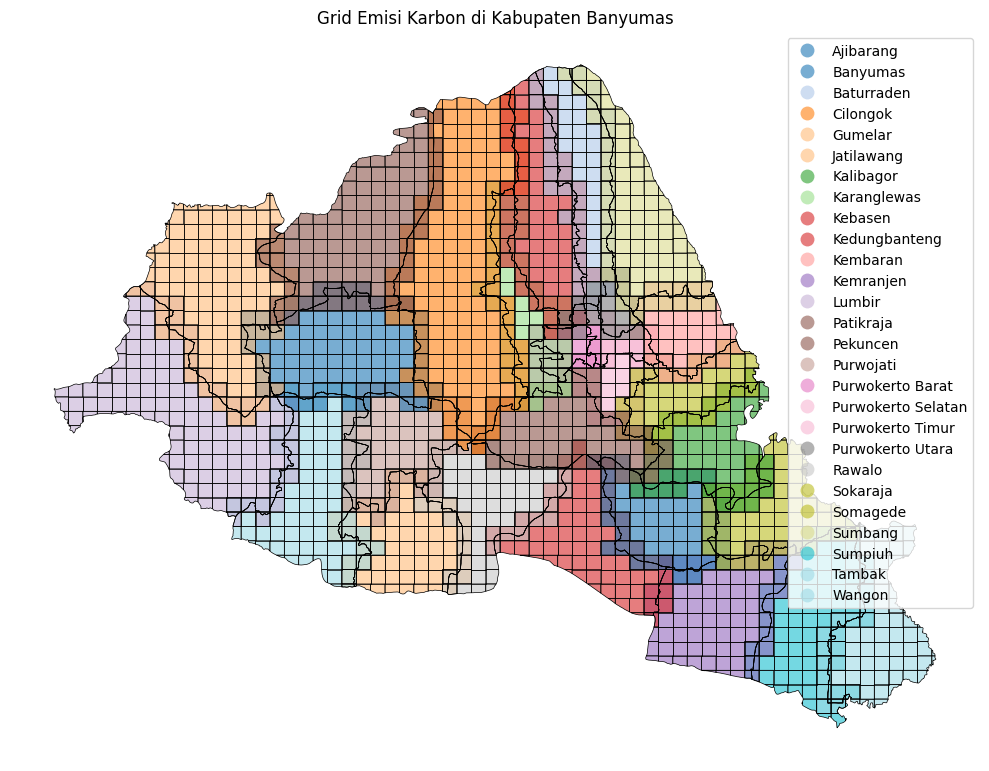

In [17]:
df_geo = gpd.read_file(r"E:\KULIAH SEMESTER 7\COMPUTING PROJECT\CAPSTONEPROJECT\grid_emisi_banyumas_kecamatan.geojson")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
df_geo.boundary.plot(ax=ax, linewidth=0.5, color="black")
df_geo.plot(ax=ax, column="kecamatan", cmap="tab20", alpha=0.6, legend=True)
plt.title("Grid Emisi Karbon di Kabupaten Banyumas")
plt.axis("off")
plt.tight_layout()
plt.show()

In [19]:
df = pd.read_csv("data_emisi_grid_banyumas.csv")

df["kepadatan_bangunan"] = df["luas_bangunan_m2"] / grid_size
df["kepadatan_jalan"] = df["panjang_jalan_m"] / grid_size
df["persentase_hijau"] = df["luas_hijau_m2"] / grid_size * 100

# Hitung skor emisi
α, β, γ = 0.3, 0.6, 0.1
df["emisi_score"] = (
    α * df["kepadatan_jalan"] +
    β * df["kepadatan_bangunan"] -
    γ * df["persentase_hijau"]
)

In [22]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

# Baca dataset
df = pd.read_csv(r"E:\KULIAH SEMESTER 7\COMPUTING PROJECT\CAPSTONEPROJECT\data_emisi_banyumas_kecamatan.csv")

# Hapus baris tanpa kecamatan
df = df.dropna(subset=["kecamatan"]).reset_index(drop=True)

# Tambah fitur rasio
df["rasio_hijau_bangunan"] = df["luas_hijau_m2"] / (df["luas_bangunan_m2"] + 1)
df["rasio_jalan_bangunan"] = df["panjang_jalan_m"] / (df["luas_bangunan_m2"] + 1)

# Hitung skor emisi (semakin banyak bangunan & jalan → emisi tinggi, semakin banyak hijau → emisi rendah)
a, b, c = 0.3, 0.6, 0.1
df["emisi_score"] = (
    a * (df["panjang_jalan_m"] / (df["panjang_jalan_m"].max() + 1)) +
    b * (df["luas_bangunan_m2"] / (df["luas_bangunan_m2"].max() + 1)) -
    c * (df["luas_hijau_m2"] / (df["luas_hijau_m2"].max() + 1))
)

# Buat kategori emisi
bins = [df["emisi_score"].min(), 0.33, 0.66, df["emisi_score"].max()]
labels = ["Rendah", "Sedang", "Tinggi"]
df["kategori_emisi"] = pd.cut(df["emisi_score"], bins=bins, labels=labels, include_lowest=True)

# Bagi kecamatan untuk train/test
train_kecamatan = ["Purwokerto Selatan", "Purwokerto Barat", "Purwokerto Timur", "Baturraden", "Sokaraja"]
test_kecamatan = ["Kalibagor", "Somagede"]

df_train = df[df["kecamatan"].isin(train_kecamatan)]
df_test  = df[df["kecamatan"].isin(test_kecamatan)]

# Tentukan fitur dan label
fitur = [
    "luas_hijau_m2", "luas_bangunan_m2", "panjang_jalan_m",
    "rasio_hijau_bangunan", "rasio_jalan_bangunan"
]
X_train = df_train[fitur]
y_train = df_train["kategori_emisi"]

X_test = df_test[fitur]
y_test = df_test["kategori_emisi"]

# ====== Undersampling ======
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print("Sebelum undersampling:", y_train.value_counts().to_dict())
print("Sesudah undersampling:", y_resampled.value_counts().to_dict())


Sebelum undersampling: {'Rendah': 325, 'Sedang': 36, 'Tinggi': 4}
Sesudah undersampling: {'Rendah': 4, 'Sedang': 4, 'Tinggi': 4}


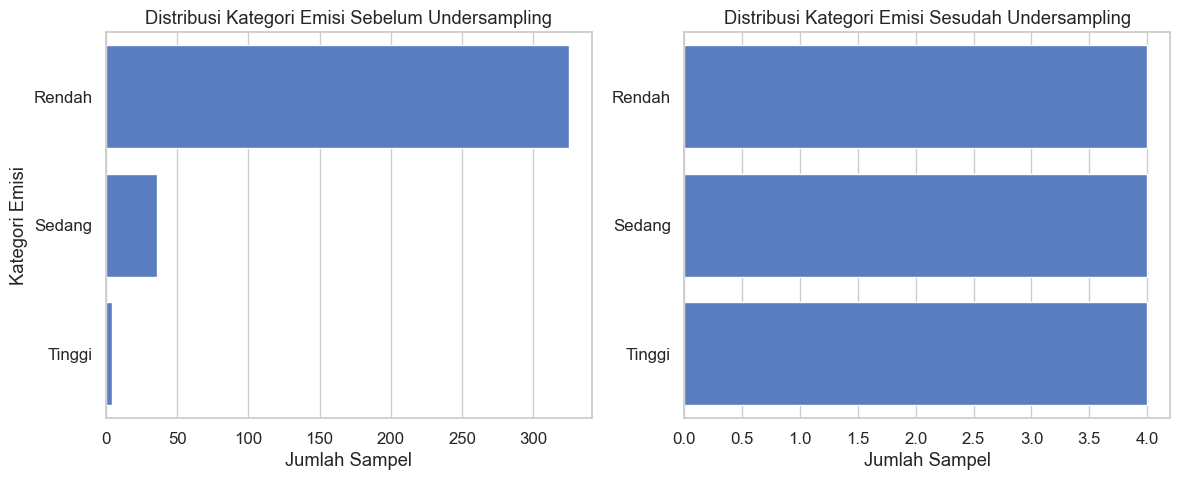

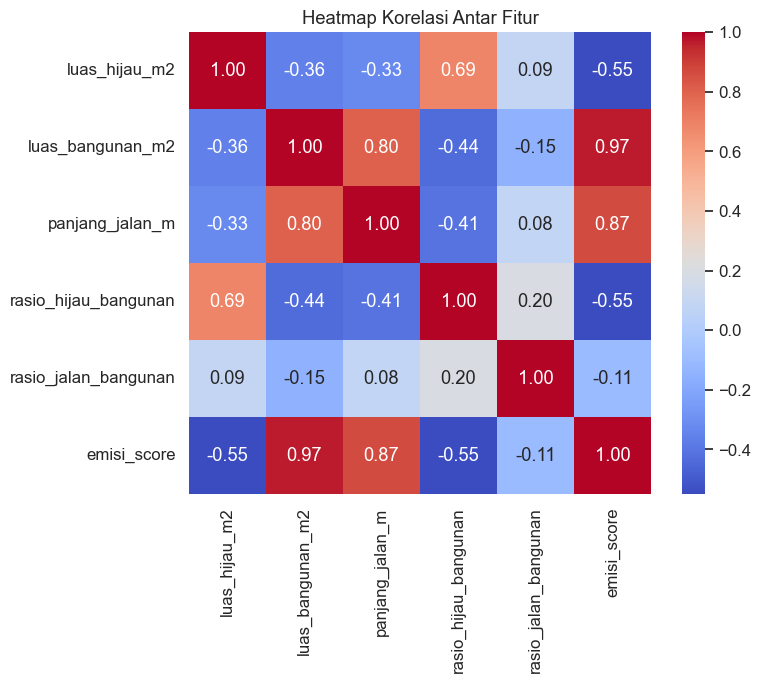

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4180\1018135949.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="kategori_emisi", y="emisi_score", data=df, palette="Set2")


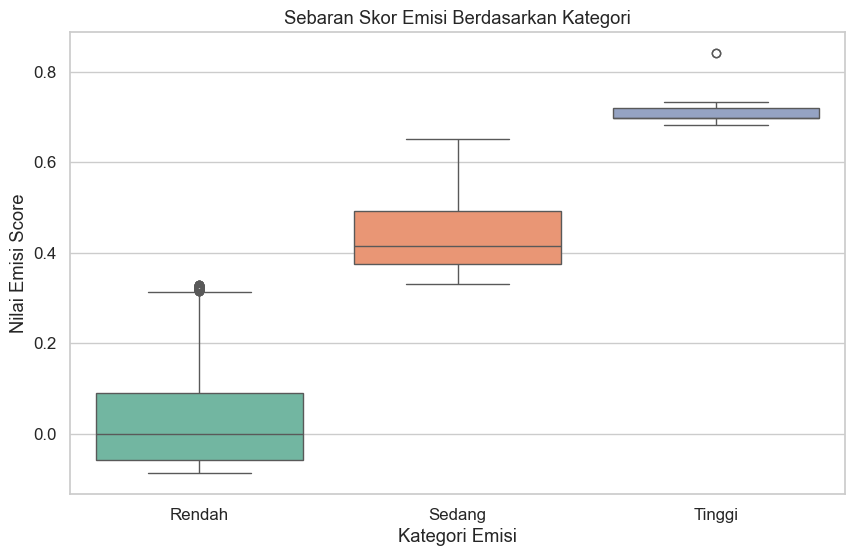

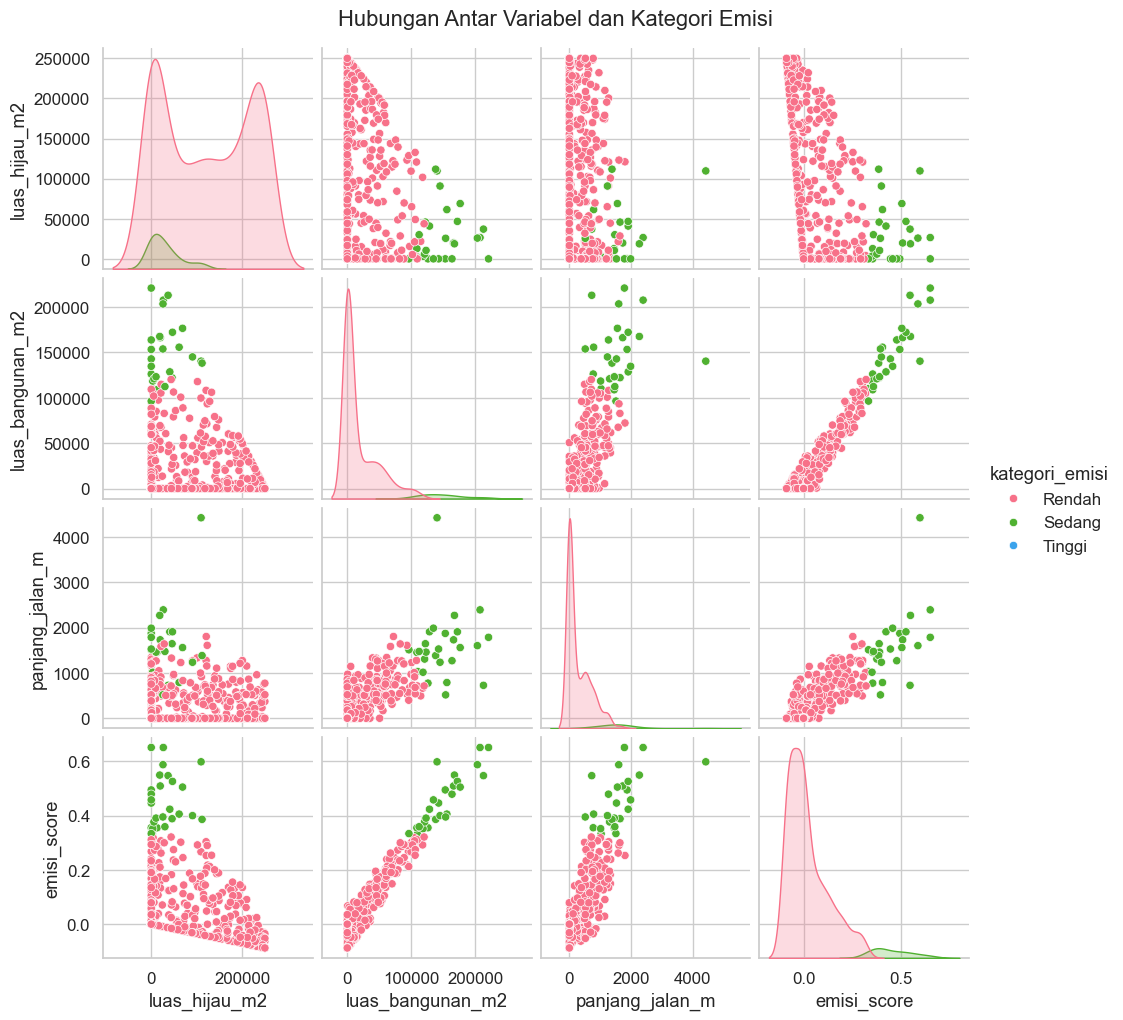

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan grafik tampil dengan gaya yang enak dibaca
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# ============================================================
# 1️⃣ Distribusi Kategori Emisi Sebelum & Sesudah Undersampling
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Sebelum undersampling
sns.countplot(y=y_train, ax=axes[0], order=y_train.value_counts().index)
axes[0].set_title("Distribusi Kategori Emisi Sebelum Undersampling")
axes[0].set_xlabel("Jumlah Sampel")
axes[0].set_ylabel("Kategori Emisi")

# Sesudah undersampling
sns.countplot(y=y_resampled, ax=axes[1], order=y_resampled.value_counts().index)
axes[1].set_title("Distribusi Kategori Emisi Sesudah Undersampling")
axes[1].set_xlabel("Jumlah Sampel")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

# ============================================================
# 2️⃣ Korelasi antar fitur numerik
# ============================================================

plt.figure(figsize=(8,6))
corr = df[[
    "luas_hijau_m2", "luas_bangunan_m2", "panjang_jalan_m",
    "rasio_hijau_bangunan", "rasio_jalan_bangunan", "emisi_score"
]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Heatmap Korelasi Antar Fitur")
plt.show()

# ============================================================
# 3️⃣ Sebaran fitur berdasarkan kategori emisi
# ============================================================

plt.figure(figsize=(10,6))
sns.boxplot(x="kategori_emisi", y="emisi_score", data=df, palette="Set2")
plt.title("Sebaran Skor Emisi Berdasarkan Kategori")
plt.xlabel("Kategori Emisi")
plt.ylabel("Nilai Emisi Score")
plt.show()

# ============================================================
# 4️⃣ Hubungan antar variabel dengan Pairplot
# ============================================================

sns.pairplot(
    df.sample(min(500, len(df))),  # ambil sebagian data biar cepat
    vars=["luas_hijau_m2", "luas_bangunan_m2", "panjang_jalan_m", "emisi_score"],
    hue="kategori_emisi",
    palette="husl",
    diag_kind="kde"
)
plt.suptitle("Hubungan Antar Variabel dan Kategori Emisi", y=1.02)
plt.show()


In [26]:
# Bagi skor emisi ke dalam 3 kategori: normal, sedang, parah (pakai quantile)

# Hitung batas quantile
q1 = df["emisi_score"].quantile(0.33)
q2 = df["emisi_score"].quantile(0.66)

# Fungsi untuk memberi label berdasarkan nilai emisi
def label_emisi(score):
    if score <= q1:
        return "normal"
    elif score <= q2:
        return "sedang"
    else:
        return "parah"

# Terapkan fungsi pada kolom emisi_score
df["kategori_emisi"] = df["emisi_score"].apply(label_emisi)

# Simpan hasil ke file baru
df.to_csv("data_emisi_grid_banyumas_labeled.csv", index=False)

print("✅ Data dengan label kategori emisi tersimpan di: data_emisi_grid_banyumas_labeled.csv")


✅ Data dengan label kategori emisi tersimpan di: data_emisi_grid_banyumas_labeled.csv


In [27]:
# Label encoding
le = LabelEncoder()
y_resampled_encoded = le.fit_transform(y_resampled)
y_test_encoded = le.transform(y_test)

classes = le.classes_  # ['normal', 'parah', 'sedang']
class_indices = list(range(len(classes)))  # [0, 1, 2]

DATA SPLITING DAN OVERSAMPLING

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4180\4014303838.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_before, x="kategori_emisi", palette="Blues", ax=axes[0])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4180\4014303838.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_after, x="kategori_emisi", palette="Greens", ax=axes[1])


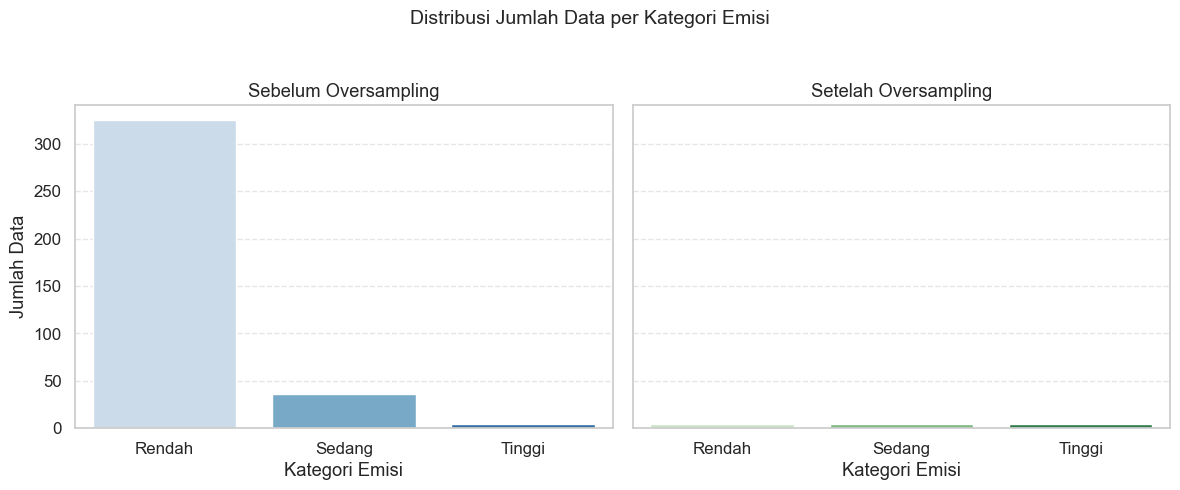

In [ ]:
# df_before = pd.DataFrame(X_train, columns=fitur)
# df_before["kategori_emisi"] = y_train.values
# df_before["status"] = "Sebelum Oversampling"

# df_after = pd.DataFrame(X_resampled, columns=fitur)
# df_after["kategori_emisi"] = y_resampled.values
# df_after["status"] = "Setelah Oversampling"

# fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# # Sebelum normalisasi
# sns.countplot(data=df_before, x="kategori_emisi", palette="Blues", ax=axes[0])
# axes[0].set_title("Sebelum Oversampling")
# axes[0].set_xlabel("Kategori Emisi")
# axes[0].set_ylabel("Jumlah Data")
# axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# # Setelah normalisasi
# sns.countplot(data=df_after, x="kategori_emisi", palette="Greens", ax=axes[1])
# axes[1].set_title("Setelah Oversampling")
# axes[1].set_xlabel("Kategori Emisi")
# axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# plt.suptitle("Distribusi Jumlah Data per Kategori Emisi", fontsize=14)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()

TRAINING MODEL

Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

✅ Akurasi Prediksi Keseluruhan: 0.9249 (92.49%)

📋 Classification Report:
              precision    recall  f1-score   support

      Rendah       1.00      0.93      0.97       180
      Sedang       0.68      0.86      0.76        29
      Tinggi       0.50      1.00      0.67         4

    accuracy                           0.92       213
   macro avg       0.73      0.93      0.80       213
weighted avg       0.95      0.92      0.93       213



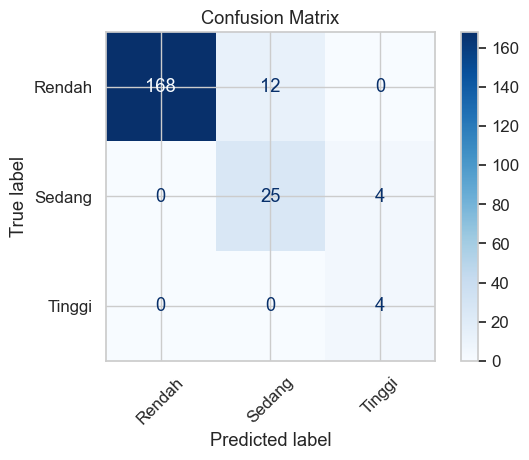

In [29]:
best_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}
grid = GridSearchCV(SVC(probability=True), best_params, cv=3)
grid.fit(X_resampled, y_resampled_encoded)

print("Best Params:", grid.best_params_)

# Kalibrasi model terbaik dari GridSearch
calibrated_model = CalibratedClassifierCV(grid.best_estimator_, cv=3, method="isotonic")
calibrated_model.fit(X_resampled, y_resampled_encoded)

# Prediksi & evaluasi
y_pred = calibrated_model.predict(X_test)
y_score = calibrated_model.predict_proba(X_test)

# Akurasi keseluruhan
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"\n✅ Akurasi Prediksi Keseluruhan: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

# Classification Report
print("📋 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=classes))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test_encoded, y_pred, display_labels=classes, cmap="Blues", xticks_rotation=45
)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


VISUALISASI ROC


 Evaluasi Binary Manual + ROC Curve per Kelas (threshold = 0.3):

🟨 Kelas 'Rendah' vs bukan_Rendah
              precision    recall  f1-score   support

      Rendah       1.00      0.93      0.97       180
bukan_Rendah       0.73      1.00      0.85        33

    accuracy                           0.94       213
   macro avg       0.87      0.97      0.91       213
weighted avg       0.96      0.94      0.95       213

🟨 Kelas 'Sedang' vs bukan_Sedang
              precision    recall  f1-score   support

      Sedang       0.52      0.86      0.65        29
bukan_Sedang       0.98      0.88      0.92       184

    accuracy                           0.87       213
   macro avg       0.75      0.87      0.79       213
weighted avg       0.91      0.87      0.89       213

🟨 Kelas 'Tinggi' vs bukan_Tinggi
              precision    recall  f1-score   support

      Tinggi       0.50      1.00      0.67         4
bukan_Tinggi       1.00      0.98      0.99       209

    accuracy    

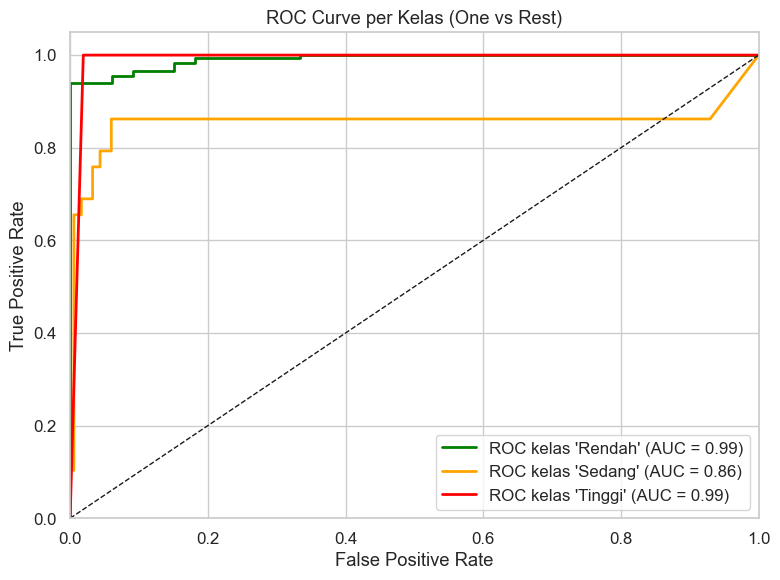

In [30]:
threshold = 0.3

print(f"\n Evaluasi Binary Manual + ROC Curve per Kelas (threshold = {threshold}):\n")

plt.figure(figsize=(8, 6))
colors = ['green', 'orange', 'red']
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, label in enumerate(classes):
    proba = y_score[:, i]

    # ROC Curve
    y_true_binary = np.where(y_test_encoded == i, 1, 0)  # 1 = target, 0 = lainnya
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, proba)
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"ROC kelas '{label}' (AUC = {roc_auc[i]:.2f})")

    # Evaluasi threshold binary manual
    y_pred_manual = np.where(proba >= threshold, label, f"bukan_{label}")
    y_true_label = np.where(y_test_encoded == i, label, f"bukan_{label}")

    print(f"🟨 Kelas '{label}' vs bukan_{label}")
    print(classification_report(y_true_label, y_pred_manual))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Kelas (One vs Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Daftar kelas: ['Rendah' 'Sedang' 'Tinggi']


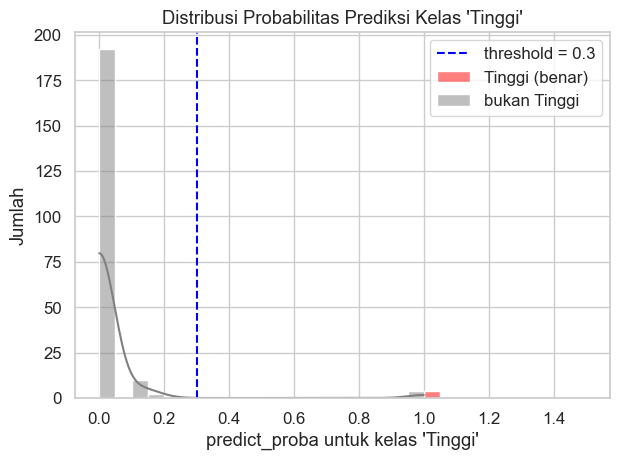

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Cek nama kelas yang dikenali model
print("Daftar kelas:", classes)

# Cek apakah label 'Tinggi' tersedia
if "Tinggi" in classes or "tinggi" in classes:
    # Tentukan nama kelas tertinggi yang ada di daftar
    target_label = "Tinggi" if "Tinggi" in classes else "tinggi"
    
    # Ambil indeks kelas
    parah_index = list(classes).index(target_label)
    
    # Probabilitas prediksi untuk kelas 'Tinggi'
    probs = y_score[:, parah_index]

    mask_parah = (y_test_encoded == parah_index)
    mask_non_parah = (y_test_encoded != parah_index)

    sns.histplot(probs[mask_parah], color='red', label=f"{target_label} (benar)", bins=20, kde=True)
    sns.histplot(probs[mask_non_parah], color='gray', label="bukan "+target_label, bins=20, kde=True)
    plt.axvline(threshold, color='blue', linestyle='--', label=f"threshold = {threshold}")
    plt.title(f"Distribusi Probabilitas Prediksi Kelas '{target_label}'")
    plt.xlabel(f"predict_proba untuk kelas '{target_label}'")
    plt.ylabel("Jumlah")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Kelas 'Tinggi' tidak ditemukan di daftar classes:", classes)


In [34]:
# Gabung prediksi
df_test["prediksi_kategori"] = y_pred

df_test.to_csv("D:/college_dump/PKL/PREDIKSI EMISI KARBON/hasil_prediksi_MLP.csv", index=False)
print(" Prediksi disimpan ke: hasil_prediksi_SVM.csv")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4180\2999417632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediksi_kategori"] = y_pred


OSError: Cannot save file into a non-existent directory: 'D:\college_dump\PKL\PREDIKSI EMISI KARBON'

In [19]:
def rekap_prediksi_semua_kecamatan(df_grid, model):
    semua_kecamatan = df_grid["kecamatan"].unique()
    hasil_list = []

    luas_grid_m2 = 1_000_000

    df_grid["rasio_hijau_bangunan"] = df_grid["luas_hijau_m2"] / (df_grid["luas_bangunan_m2"] + 1)
    df_grid["rasio_jalan_bangunan"] = df_grid["panjang_jalan_m"] / (df_grid["luas_bangunan_m2"] + 1)

    for kec in semua_kecamatan:
        data_kec = df_grid[df_grid["kecamatan"] == kec]

        if data_kec.empty:
            continue

        X = data_kec[["luas_hijau_m2", "luas_bangunan_m2", "panjang_jalan_m", "rasio_hijau_bangunan", "rasio_jalan_bangunan"]]
        pred = model.predict(X)

        data_kec = data_kec.copy()
        data_kec["prediksi_kategori"] = pred

        # Rata-rata hasil
        kategori_dominan = data_kec["prediksi_kategori"].mode()[0]
        skor_emisi = data_kec["emisi_score"].mean() if "emisi_score" in data_kec.columns else None
        kepadatan_jalan = (data_kec["panjang_jalan_m"] / luas_grid_m2).mean() * 1000
        kepadatan_bangunan = (data_kec["luas_bangunan_m2"] / luas_grid_m2).mean()
        persentase_hijau = (data_kec["luas_hijau_m2"] / luas_grid_m2).mean() * 100

        hasil_list.append({
            "kecamatan": kec,
            "kategori_emisi": kategori_dominan,
            "rata_skor_emisi": skor_emisi,
            "kepadatan_jalan_km/km2": kepadatan_jalan,
            "kepadatan_bangunan_m2/km2": kepadatan_bangunan,
            "persentase_area_hijau": persentase_hijau
        })

    df_hasil = pd.DataFrame(hasil_list)

    df_hasil.to_csv("D:/college_dump/PKL/PREDIKSI EMISI KARBON/rekap_prediksi_SVM.csv", index=False)
    print(f" Rekap prediksi berhasil disimpan")

    return df_hasil

In [20]:
df_grid = pd.read_csv("D:/college_dump/PKL/PREDIKSI EMISI KARBON/data_emisi_banyumas_kecamatan.csv")
hasil_rekap = rekap_prediksi_semua_kecamatan(df_grid, calibrated_model)

 Rekap prediksi berhasil disimpan


In [21]:
df1 = pd.read_csv("D:/college_dump/PKL/PREDIKSI EMISI KARBON/rekap_prediksi_SVM.csv")
df2 = pd.read_csv("D:/college_dump/PKL/PREDIKSI EMISI KARBON/titik_kecamatan_banyumas.csv")

# Merge berdasarkan kolom kecamatan
gabung_df = pd.merge(df1, df2, on="kecamatan", how="inner")  # atau outer, left, right

gabung_df.to_csv("hasil_merge_SVM.csv", index=False)

In [22]:
df = pd.read_csv("D:/college_dump/PKL/PREDIKSI EMISI KARBON/hasil_merge_SVM.csv")

mapping = {
    0: "normal",
    1: "parah",
    2: "sedang"
}

df["kategori_emisi"] = df["kategori_emisi"].map(mapping)

df.to_csv("hasil_merge_SVM_labeled.csv", index=False)
print(df.head())

   kecamatan kategori_emisi  rata_skor_emisi  kepadatan_jalan_km/km2  \
0     Lumbir         normal     -4454.673789                0.744858   
1    Gumelar         sedang     -4153.856938                0.966444   
2     Wangon         sedang     -3023.849190                1.204302   
3  Ajibarang         sedang     -2608.399787                1.401562   
4   Pekuncen         normal     -3757.069669                1.280040   

   kepadatan_bangunan_m2/km2  persentase_area_hijau  latitude   longitude  
0                   0.056013              44.885051 -7.465615  108.975399  
1                   0.078569              42.012884 -7.388697  108.996527  
2                   0.092306              30.795942 -7.512976  109.054098  
3                   0.121228              26.815569 -7.425407  109.072875  
4                   0.085234              38.085943 -7.348280  109.083898  
